In [465]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
    tgrad = np.array(dic['tgrad'])[mask]
    tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    
    
    pdub = np.array([650]*len(tlow))
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetae_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)
    
    thetae_down = u_met.theta_e(925, tlow-273.15, qq)
    
    thetae = thetae_down - thetae_up
    
    theta_up = u_met.theta(650, tup-273.15)
    theta_down = u_met.theta(925, tlow-273.15)
    
    theta = theta_down - theta_up
    
    if tgrad.ndim == 2:
        tgrad = tlow
    if tbox.ndim == 2:
        tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
        'theta_e' : thetae,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcwv' : tcwv,
        'tgrad' : tgrad.squeeze(),
        'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [4]:
def create_dic_model(dic):
    
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) + 0.5
    tup = np.array(dic['t'])
    tcwv = np.array(dic['tcwv'])
    tgrad = np.array(dic['tgrad'])
    tbox = np.array(dic['tdiff'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    tsrfc = np.array(dic['tsrfcmax']) + 3
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    try:
        thetamax = np.array(dic['thetamax'])
        thetamean = np.array(dic['thetamean'])   
    except:
        pass

    obs_pcp = {
        'prcp' : pp,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq,
        't925' : tsrfc,
        'tcwv' : tcwv,
        'tgrad' : tgrad,
        'tbox' : tbox,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    
    try:
        obs_pcp['theta_e']=thetamax +4
        #obs_pcp['thetamean']=thetamean
    except:
        pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [5]:
cp4_histf = ('modelhist', cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4means_hourly_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_hist_*.p')
cp4_futf = ('modelfut' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4means_hourly_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_fut_*.p')
gpmf = ('obs' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_hourly_*.p')
dlist = [cp4_histf,cp4_futf,gpmf]

In [6]:
for d in dlist:
    
    #ipdb.set_trace()
    ds = glob.glob(d[1])
    
    
    
    for ids, dss in enumerate(ds):
        data = pkl.load( open (dss, 'rb'))
        #data.update(dat)
        
        if 'model' in d[0]:
            if d[0] == 'modelhist':
                cp4_h = create_dic_model(data)
                if ids > 0:
                    histf = pd.concat([histf, cp4_h])
                else:
                    histf = cp4_h    
            else:
                cp4_f = create_dic_model(data)
                if ids > 0:
                    futf = pd.concat([futf, cp4_f])
                else:
                    futf = cp4_f
        if 'obs' in d[0]:
            if d[0] == 'obsm':
                obs_gpmc_m = create_dic(data)
                if ids > 0:
                    obs_gpmc = pd.concat([obs_gpmc, obs_gpmc_m])
                else:
                    obs_gpmc = obs_gpmc_m
            else:
                obs_gpmf_h = create_dic(data)
                if ids > 0:
                    obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
                else:
                    obs_gpmf = obs_gpmf_h
                    

        del data

In [7]:
obs_gpmf.head()

,prcp,q925,q650,t925,shear,month,area,tmin,rh,theta_e,tcwv,tgrad,tbox,lat,lon
0,33.945941,16.032429,5.258263,21.451288,21.597702,9,6350,-80.861286,92.476395,-1.875311,50.086918,0.174528,3.371307,15.337195,-11.309676
1,4.216382,13.945688,6.594621,21.226892,-3.408928,8,9500,-66.841842,80.737831,-5.912872,47.465511,0.115285,0.348175,11.320022,-12.558099
2,59.185143,14.722182,4.939521,24.223535,20.380962,7,109950,-84.518429,71.706879,-2.340344,46.883617,0.169490,4.454224,15.367470,-12.196891
3,2.248306,17.130347,6.434912,21.410577,18.177017,8,19025,-69.398859,99.019821,5.916224,59.113689,0.239586,0.140045,17.328758,-12.240657
4,43.297786,16.088208,5.281735,27.334863,20.113298,6,190925,-88.485493,65.269966,5.452407,48.521294,0.178521,4.899445,11.785741,6.625053


In [8]:
futf['theta_e']

0        3.411888
1        0.321610
2       -2.406928
3        3.044450
4       -1.684204
           ...   
10228    8.769810
10229    1.988148
10230    6.514574
10231    7.332697
10232    7.545776
Name: theta_e, Length: 99291, dtype: float64

In [9]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

17.824957782145926
9.000161827841007
12.107882421128927
-14.998084590200353


In [529]:
tag = 'Sahel'
domainSA = [-10,12,5,8.5]
domainSS = [-12,12,9,18]  # 8.5, 17.5
domainWA = [-10,12,5,17.5]
nb = 21
region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(11.5,19.5,nb) , np.linspace(5,28,nb), np.linspace(-7.9,6,nb), np.linspace(20,90,nb)],  #np.linspace(10,17.5,17) , np.linspace(0,25,17)
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-7.9,6,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-7.9,7.9,nb), np.linspace(20,92,nb)],
         }

domain = region[tag][0]
tname = region[tag][1]
qbins = region[tag][2]
shearbins = region[tag][3]
thetabins = region[tag][4]
tcwvbins=region[tag][5]
qshearbins = qbins*shearbins

m1 = 3
m2 = 11
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [346]:
print('hist', hist.lat.min(), hist.lat.max(), hist.lon.min(), hist.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

hist 9.008251190185547 17.99925422668457 -11.76275634765625 11.990509033203125
OBS_gpm 9.000161827841007 17.74562661158754 -11.999380172064235 11.996942654145766


Text(0.5,1,'-0.57')

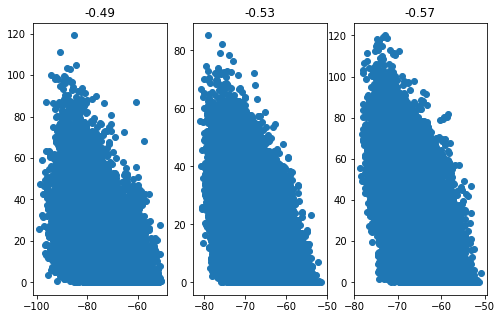

In [347]:

cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm
cp25s = [hist.tmin, hist.prcp] #cp4
futur = [fut.tmin, fut.prcp] 


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))





Text(0.5,1,'-0.47')

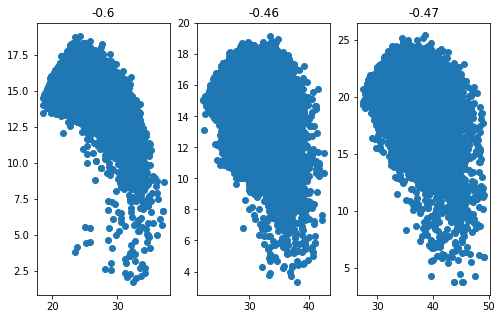

In [348]:

cp4s = [obs_gpm.t925, obs_gpm.q925] # gpm
cp25s = [hist.t925, hist.q925] #cp4
futur = [fut.t925, fut.q925] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

In [349]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

#     rr = stats.pearsonr(v1,v2)
#     print('pears', stats.pearsonr(v1,v2))
    
    return data

In [350]:
obs = obs_gpm
gpm = [obs.tcwv[(obs.prcp>=5)&(obs.tcwv>=5)&(obs.shear>=8)], obs.prcp[(obs.prcp>=5)&(obs.tcwv>=5)&(obs.shear>=8)]] # gpm
cp4h = [hist.tcwv[(hist.prcp>=5)&(hist.tcwv>=5)&(hist.shear>=8)], hist.prcp[(hist.prcp>=5)&(hist.tcwv>=5)&(hist.shear>=8)]] #cp4
cp4f = [fut.tcwv[(fut.prcp>=5)&(fut.tcwv>=5)&(fut.shear>=8)], fut.prcp[(fut.prcp>=5)&(fut.tcwv>=5)&(fut.shear>=8)]] #cp4

def statsi(x,y):
    data = density_plot(x, y)
    #slope, intercept, r, p_value, std_err = stats.linregress(cp4h[0], cp4h[1])
    inter, slope= P.polyfit(x,y,1)#,w=data)

    return data, slope, inter
    
gdata, gslope, gintercept = statsi(gpm[0], gpm[1])
hdata,hslope, hintercept = statsi(cp4h[0], cp4h[1])
fdata,fslope, fintercept = statsi(cp4f[0], cp4f[1])
    

f = plt.figure(figsize=(14,5), dpi=200)
ax = f.add_subplot(121)

#data, r = density_plot(gpm[0], gpm[1])
#slope, intercept, r, p_value, std_err = stats.linregress(gpm[0], gpm[1])


perc = np.percentile(gpm[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*gslope+gintercept, linestyle='dashed', label=r'OBS | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(gslope,3)), linewidth=3)
plt.ylim(-0.5,90)
plt.xlim(-15,100)
plt.xlabel('TCWV')
plt.ylabel('Precip')

perc = np.percentile(cp4h[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*hslope+hintercept, linestyle='dashed', label=r'CP4hist | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(hslope,3)), color='k')
plt.ylim(-0.5,90)
plt.xlim(-15,100)
plt.xlabel('TCWV')
plt.ylabel('Precip')
plt.title('OBS vs CP4 historical')
plt.legend(loc='upper left')

plt.scatter(gpm[0],gpm[1], c=gdata, cmap='winter', alpha=0.5, label='OBS prcp')
plt.scatter(cp4h[0],cp4h[1], c=hdata, cmap='viridis_r', label='CP4h prcp')

plt.colorbar(label='Density')

ax = f.add_subplot(122)


perc = np.percentile(cp4f[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*fslope+fintercept, linestyle='dashed', label=r'CP4fut | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(fslope,3)), color='red')
plt.ylim(-0.5,90)
plt.xlim(-15,100)
plt.xlabel('TCWV')
plt.ylabel('Precip')



perc = np.percentile(cp4h[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*hslope+hintercept, linestyle='dashed', label=r'CP4hist | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(hslope,3)), color='k')
plt.ylim(-0.5,90)
plt.xlim(-15,100)
plt.xlabel('TCWV')
plt.ylabel('Precip')
plt.title('CP4 historical vs CP4 future')
plt.legend(loc='upper left')

plt.scatter(cp4f[0],cp4f[1], c=fdata, cmap='inferno_r')

plt.scatter(cp4h[0],cp4h[1], c=hdata, cmap='viridis_r')

plt.colorbar(label='Density')

plt.tight_layout()

f.savefig(cnst.network_data +'figs/ENDGAME/precip_tcw_scatter_'+tag+'_ALL_hourly.png')

KeyboardInterrupt: 

In [ ]:
obs = obs_gpm
gpm = [obs.tcwv[(obs.prcp>=5)&(obs.tcwv>=5)&(obs.shear>=5)], obs.prcp[(obs.prcp>=5)&(obs.tcwv>=5)&(obs.shear>=5)]] # gpm
cp4h = [hist.tcwv[(hist.prcp>=5)&(hist.tcwv>=5)&(hist.shear>=5)], hist.prcp[(hist.prcp>=5)&(hist.tcwv>=5)&(hist.shear>=5)]] #cp4
cp4f = [fut.tcwv[(fut.prcp>=5)&(fut.tcwv>=5)&(fut.shear>=5)], fut.prcp[(fut.prcp>=5)&(fut.tcwv>=5)&(fut.shear>=5)]] #cp4

plotgperc = np.percentile(gpm[0],[1,99])
plothperc = np.percentile(cp4h[0],[1,99])
plotfperc = np.percentile(cp4f[0],[1,99])


gpmp = np.percentile(gpm[0], [5,93])
cp4hp  = np.percentile(cp4h[0], [5,93])
cp4fp = np.percentile(cp4f[0], [5,93])

gmask = (gpm[0]>=gpmp[0])&(gpm[0]<=gpmp[1])
hmask = (cp4h[0]>=cp4hp[0])&(cp4h[0]<=cp4hp[1])
fmask = (cp4f[0]>=cp4fp[0])&(cp4f[0]<=cp4fp[1])

pgmask = (gpm[1]<=np.percentile(gpm[1], 98))
phmask = (cp4h[1]<=np.percentile(cp4h[1], 98))
pfmask = (cp4f[1]<=np.percentile(cp4f[1], 98))

#ipdb.set_trace()

gpm[0] = gpm[0][gmask]#&pgmask]
cp4h[0] = cp4h[0][hmask]#&phmask]
cp4f[0] = cp4f[0][fmask]#&pfmask]
gpm[1] = gpm[1][gmask]#&pgmask]
cp4h[1] = cp4h[1][hmask]#&phmask]
cp4f[1] = cp4f[1][fmask]#&pfmask]


def statsi(x,y):
    data = density_plot(x, y)
    #slope, intercept, r, p_value, std_err = stats.linregress(cp4h[0], cp4h[1])
    inter, slope= P.polyfit(x,y,1)#,w=data)

    return data, slope, inter
    
gdata, gslope, gintercept = statsi(gpm[0], gpm[1])
hdata,hslope, hintercept = statsi(cp4h[0], cp4h[1])
fdata,fslope, fintercept = statsi(cp4f[0], cp4f[1])
    

f = plt.figure(figsize=(14,5), dpi=200)
ax = f.add_subplot(121)

#data, r = density_plot(gpm[0], gpm[1])
#slope, intercept, r, p_value, std_err = stats.linregress(gpm[0], gpm[1])



plt.plot(np.arange(plotgperc[0],plotgperc[1]), np.arange(plotgperc[0],plotgperc[1])*gslope+gintercept, linestyle='dashed', label=r'OBS | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(gslope,3)), linewidth=3)
plt.ylim(-0.5,95)
plt.xlim(5,80)
plt.xlabel('TCWV')
plt.ylabel('Precip')

perc = np.percentile(cp4h[0],[1,99])
plt.plot(np.arange(plothperc[0],plothperc[1]), np.arange(plothperc[0],plothperc[1])*hslope+hintercept, linestyle='dashed', label=r'CP4hist | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(hslope,3)), color='k')
plt.ylim(-0.5,95)
plt.xlim(5,80)
plt.xlabel('TCWV')
plt.ylabel('Precip')
plt.title('OBS vs CP4 historical')
plt.legend(loc='upper left')

plt.scatter(gpm[0],gpm[1], c=gdata, cmap='winter', alpha=0.5, label='OBS prcp')
plt.scatter(cp4h[0],cp4h[1], c=hdata, cmap='viridis_r', label='CP4h prcp')

plt.colorbar(label='Density')

ax = f.add_subplot(122)


perc = np.percentile(cp4f[0],[0,100])
plt.plot(np.arange(plotfperc[0],plotfperc[1]), np.arange(plotfperc[0],plotfperc[1])*fslope+fintercept, linestyle='dashed', label=r'CP4fut | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(fslope,3)), color='red')
plt.ylim(-0.5,95)
plt.xlim(5,80)
plt.xlabel('TCWV')
plt.ylabel('Precip')


perc = np.percentile(cp4h[0],[0,100])
plt.plot(np.arange(plothperc[0],plothperc[1]), np.arange(plothperc[0],plothperc[1])*hslope+hintercept, linestyle='dashed', label=r'CP4hist | $\dfrac{\delta Pmax}{TCW}$: ' + str(np.round(hslope,3)), color='k')
plt.ylim(-0.5,95)
plt.xlim(5,80)
plt.xlabel('TCWV')
plt.ylabel('Precip')
plt.title('CP4 historical vs CP4 future')
plt.legend(loc='upper left')

plt.scatter(cp4f[0],cp4f[1], c=fdata, cmap='inferno_r')

plt.scatter(cp4h[0],cp4h[1], c=hdata, cmap='viridis_r')

plt.colorbar(label='Density')

plt.tight_layout()

f.savefig(cnst.network_data +'figs/CLOVER/precip_tcw_scatter_'+tag+'_hourly.png')

In [ ]:
obs = obs_gpm
gpm = [obs.q925[(obs.prcp>=5)&(obs.tcwv>=5)&(obs.shear>=1)], obs.prcp[(obs.prcp>=5)&(obs.tcwv>=5)&(obs.shear>=1)]] # gpm
cp4h = [hist.q925[(hist.prcp>=5)&(hist.tcwv>=5)&(hist.shear>=1)], hist.prcp[(hist.prcp>=5)&(hist.tcwv>=5)&(hist.shear>=1)]] #cp4
cp4f = [fut.q925[(fut.prcp>=5)&(fut.tcwv>=5)&(fut.shear>=1)], fut.prcp[(fut.prcp>=5)&(fut.tcwv>=5)&(fut.shear>=1)]] #cp4

def statsi(x,y):
    data = density_plot(x, y)
    #slope, intercept, r, p_value, std_err = stats.linregress(cp4h[0], cp4h[1])
    inter, slope= P.polyfit(x,y,1)#,w=data)

    return data, slope, inter
    
gdata, gslope, gintercept = statsi(gpm[0], gpm[1])
hdata,hslope, hintercept = statsi(cp4h[0], cp4h[1])
fdata,fslope, fintercept = statsi(cp4f[0], cp4f[1])
    

f = plt.figure(figsize=(14,5), dpi=200)
ax = f.add_subplot(121)

#data, r = density_plot(gpm[0], gpm[1])
#slope, intercept, r, p_value, std_err = stats.linregress(gpm[0], gpm[1])


perc = np.percentile(gpm[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*gslope+gintercept, linestyle='dashed', label=r'OBS | $\dfrac{\delta Pmax}{q925}$: ' + str(np.round(gslope,3)), linewidth=3)
plt.ylim(-0.5,90)
plt.xlim(5,25)
plt.xlabel('q925')
plt.ylabel('Precip')

perc = np.percentile(cp4h[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*hslope+hintercept, linestyle='dashed', label=r'CP4hist | $\dfrac{\delta Pmax}{q925}$: ' + str(np.round(hslope,3)), color='k')
plt.ylim(-0.5,90)
plt.xlim(5,25)
plt.xlabel('q925')
plt.ylabel('Precip')
plt.title('OBS vs CP4 historical')
plt.legend(loc='upper left')

plt.scatter(gpm[0],gpm[1], c=gdata, cmap='winter', alpha=0.5, label='OBS prcp')
plt.scatter(cp4h[0],cp4h[1], c=hdata, cmap='viridis_r', label='CP4h prcp')

plt.colorbar(label='Density')

ax = f.add_subplot(122)


perc = np.percentile(cp4f[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*fslope+fintercept, linestyle='dashed', label=r'CP4fut | $\dfrac{\delta Pmax}{q925}$: ' + str(np.round(fslope,3)), color='red')
plt.ylim(-0.5,90)
plt.xlim(5,25)
plt.xlabel('q925')
plt.ylabel('Precip')



perc = np.percentile(cp4h[0],[1,99])
plt.plot(np.arange(perc[0],perc[1]), np.arange(perc[0],perc[1])*hslope+hintercept, linestyle='dashed', label=r'CP4hist | $\dfrac{\delta Pmax}{q925}$: ' + str(np.round(hslope,3)), color='k')
plt.ylim(-0.5,90)
plt.xlim(5,25)
plt.xlabel('q925')
plt.ylabel('Precip')
plt.title('CP4 historical vs CP4 future')
plt.legend(loc='upper left')

plt.scatter(cp4f[0],cp4f[1], c=fdata, cmap='inferno_r')

plt.scatter(cp4h[0],cp4h[1], c=hdata, cmap='viridis_r')

plt.colorbar(label='Density')

plt.tight_layout()

f.savefig(cnst.network_data +'figs/CLOVER/precip_q_scatter_'+tag+'_ALL_hourly.png')

In [ ]:

cp4s = [obs_gpm.tcwv, obs_gpm.prcp] # gpm
cp25s = [hist.tcwv, hist.prcp] #cp4
futur = [fut.tcwv, fut.prcp] #cp4



f = plt.figure(figsize=(15,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title('OBS: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCWV')
plt.ylabel('Precip (mm h-1)')

ax = f.add_subplot(143)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title('CP4hist: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCWV')
plt.ylabel('Precip (mm h-1)')
#ax.set_ylim(0,50)

ax = f.add_subplot(144)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title('CP4fut: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCWV')
plt.ylabel('Precip (mm h-1)')

plt.tight_layout()

In [ ]:

cp4s = [obs_gpm.q925, obs_gpm.prcp] # gpm
cp25s = [hist.q925, hist.prcp] #cp4
futur = [fut.q925, fut.prcp] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))


#ax.set_ylim(0,50)

Text(0.5,1,'Fut 0.05')

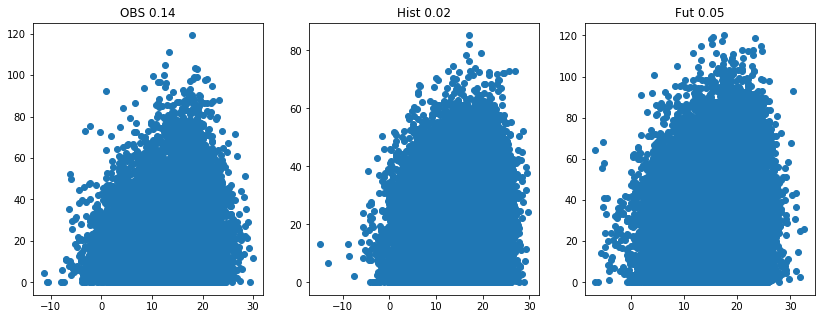

In [240]:

cp4s = [obs_gpm.shear, obs_gpm.prcp] # gpm
cp25s = [hist.shear, hist.prcp] #cp4
futur = [fut.shear, fut.prcp]


f = plt.figure(figsize=(14,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title('OBS '+str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title('Hist '+ str(np.round(r[0], decimals=2)))

ax = f.add_subplot(133)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title('Fut '+ str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)


IndexError: list index out of range

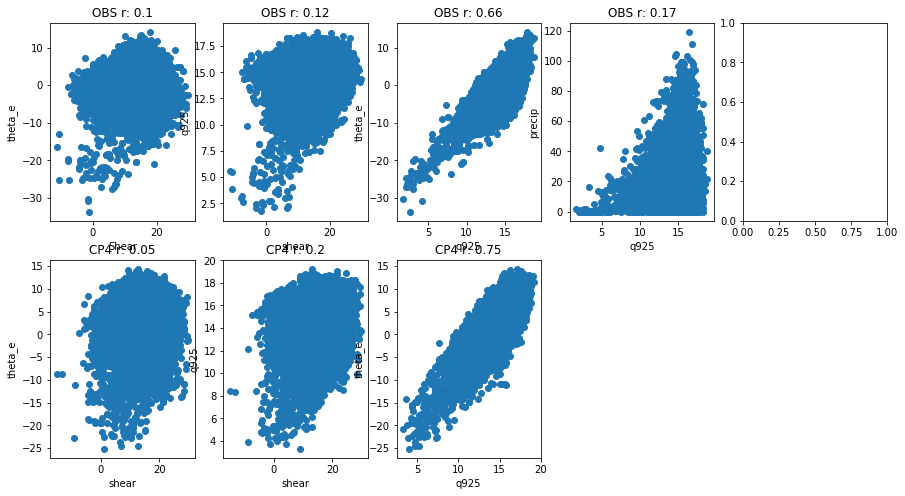

In [241]:
obss = [hist.shear, hist.theta_e, hist.q925, hist.tmin, hist.prcp, '', '', hist.tcwv] # cp4
cp4s = [obs_gpm.shear, obs_gpm.theta_e, obs_gpm.q925, obs_gpm.tmin, obs_gpm.prcp, obs_gpm.q650, obs_gpm.tcwv]  # gpm

f = plt.figure(figsize=(15,8))
ax = f.add_subplot(2,5,1)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('Shear')
plt.ylabel('theta_e')

ax = f.add_subplot(2,5,2)
r = stats.pearsonr(cp4s[0],cp4s[2])
plt.scatter(cp4s[0],cp4s[2])
plt.title('OBS r: '+ str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('q925')

ax = f.add_subplot(2,5,3)
r = stats.pearsonr(cp4s[2],cp4s[1])
plt.scatter(cp4s[2],cp4s[1])
plt.title('OBS r: '+ str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('theta_e')

ax = f.add_subplot(2,5,4)
r = stats.pearsonr(cp4s[2],cp4s[4])
plt.scatter(cp4s[2],cp4s[4])
plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('precip')


ax = f.add_subplot(2,5,6)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('theta_e')

ax = f.add_subplot(2,5,7)
plt.scatter(obss[0],obss[2])
r = stats.pearsonr(obss[0],obss[2])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('q925')

ax = f.add_subplot(2,5,8)
plt.scatter(obss[2],obss[1])
r = stats.pearsonr(obss[2],obss[1])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('theta_e')


ax = f.add_subplot(2,5,5)
plt.scatter(cp4s[7],cp4s[4])
r = stats.pearsonr(cp4s[7],cp4s[4])
plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('tcwv')
plt.ylabel('precip')

ax = f.add_subplot(2,5,10)
r = stats.pearsonr(obss[7],obss[4])
plt.scatter(obss[7],obss[4])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('tcwv')
plt.ylabel('precip')

plt.tight_layout()
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

#plt.savefig(cnst.network_data + 'figs/CLOVER/scatter_SoudanoSahel_OBS_CP4.png')

In [569]:
oposi = (obs_gpm.q925>=9.5) & (obs_gpm.shear>-5) &  (obs_gpm.prcp>=5) & (obs_gpm.theta_e>=-40) & (obs_gpm.area>=5000) & (obs_gpm.tmin<=-60) # & ((obs_gpm.month>=9) | (obs_gpm.month<=5))
cposi = (hist.q925>=9.5) & (hist.shear>-5) &  (hist.prcp>=5) & (np.isfinite(hist.q925)) & np.isfinite(hist.shear)  & (hist.area>=5000) & (hist.tmin<=-60)
fposi = (fut.q925>=9.5) & (fut.shear>-5) &  (fut.prcp>=5) & (np.isfinite(fut.q925)) & np.isfinite(fut.shear)  & (fut.area>=5000) & (fut.tmin<=-60)

In [570]:
obs = obs_gpm[oposi]
cp4 = hist[cposi]
cp4f = fut[fposi]
cp4.area = cp4.area.values

In [571]:
cp4.area.min()

5014.240000000001

In [572]:
obs.area.min()

5225

In [573]:
obs.keys()

Index(['prcp', 'q925', 'q650', 't925', 'shear', 'month', 'area', 'tmin', 'rh',
       'theta_e', 'tcwv', 'tgrad', 'tbox', 'lat', 'lon'],
      dtype='object')

In [574]:
len(obs)

26187

In [575]:
len(cp4)

53602

In [576]:
len(cp4f)

41120

In [577]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    
    for i, dat in enumerate(data):
        if (i==2) | (i==3):
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
            
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/CLOVER/OBS_CP4_2dHist_SoudanoSahel_15km_thetae_shear.png')

In [578]:
def hist2d_six_area(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        
        print(i)
        ax = f.add_subplot(2,3,i+1)
        if i in [0,1]:
            cmap = 'Reds_r'
            
        if i in [3,4]:
            cmap = 'Blues'
        if i in[2,5]:
            cmap = 'Purples'
            
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(12, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],13)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_future_50C.png')

In [579]:
def hist2d_six(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        
        print(i)
        ax = f.add_subplot(2,3,i+1)
        if i in [0,1,2]:
            cmap = 'Reds_r'
            
        if i in [3,4,5]:
            cmap = 'Blues'
            
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(12, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],13)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_future_50C.png')

In [580]:
vlist = ['prcp', 'area', 'tmin']

In [541]:
obs_q925 = hist2d.create_2dhist(obs.shear, obs.q925, shearbins, qbins, obs, vlist)
obs_theta = hist2d.create_2dhist(obs.shear, obs.theta_e, shearbins, thetabins, obs, vlist)
obs_tcwv = hist2d.create_2dhist(obs.shear, obs.tcwv, shearbins, tcwvbins, obs, vlist)

cp4_q925 = hist2d.create_2dhist(cp4.shear, cp4.q925, shearbins, qbins, cp4, vlist)
cp4_tcwv = hist2d.create_2dhist(cp4.shear, cp4.tcwv, shearbins, tcwvbins, cp4, vlist)
cp4_theta = hist2d.create_2dhist(cp4.shear, cp4.theta_e, shearbins, thetabins, cp4, vlist)

cp4f_q925 = hist2d.create_2dhist(cp4f.shear, cp4f.q925, shearbins, qbins, cp4f, vlist)
cp4f_tcwv = hist2d.create_2dhist(cp4f.shear, cp4f.tcwv, shearbins, tcwvbins, cp4f, vlist)
cp4f_theta = hist2d.create_2dhist(cp4f.shear, cp4f.theta_e, shearbins, thetabins, cp4f, vlist)

In [582]:
obs_q925 = hist2d.create_2dhist_centile(obs.shear, obs.q925, shearbins, qbins, obs, vlist, 90)
obs_theta = hist2d.create_2dhist_centile(obs.shear, obs.theta_e, shearbins, thetabins, obs, vlist, 90)
obs_tcwv = hist2d.create_2dhist_centile(obs.shear, obs.tcwv, shearbins, tcwvbins, obs, vlist, 90)

cp4_q925 = hist2d.create_2dhist_centile(cp4.shear, cp4.q925, shearbins, qbins, cp4, vlist, 90)
cp4_tcwv = hist2d.create_2dhist_centile(cp4.shear, cp4.tcwv, shearbins, tcwvbins, cp4, vlist, 90)
cp4_theta = hist2d.create_2dhist_centile(cp4.shear, cp4.theta_e, shearbins, thetabins, cp4, vlist, 90)

cp4f_q925 = hist2d.create_2dhist_centile(cp4f.shear, cp4f.q925, shearbins, qbins, cp4f, vlist, 90)
cp4f_tcwv = hist2d.create_2dhist_centile(cp4f.shear, cp4f.tcwv, shearbins, tcwvbins, cp4f, vlist, 90)
cp4f_theta = hist2d.create_2dhist_centile(cp4f.shear, cp4f.theta_e, shearbins, thetabins, cp4f, vlist, 90)

In [583]:
cp4f_q925.keys()

dict_keys(['prcp', 'prcp_val', 'area', 'area_val', 'tmin', 'tmin_val', 'xbins', 'ybins'])

In [584]:
def plot_dic_tmin(dic, vmin, vmax, xlabel, ylabel, tag):
    
    odic = {
    'data' : dic['tmin'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': minimum temperature',
    'valid' : dic['tmin_val'],
    'cbarlabel' : '${\circ}$C',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }
    return odic
    
def plot_dic_prcp(dic, vmin, vmax, xlabel, ylabel, tag):
    odic = {
    'data' : dic['prcp'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': maximum precipitation',
    'valid' : dic['prcp_val'],
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }
    return odic
    
def plot_dic_area(dic, vmin, vmax, xlabel, ylabel, tag):
    odic = {
    'data' : dic['area'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': MCS area',
    'valid' : dic['area_val'],
    'cbarlabel' : r'km$^{2}$',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }    
    return odic

In [585]:
def binning_hist(bins, shape):
    scat = np.repeat(bins,shape[1],axis=0).reshape(shape)
    return scat

In [586]:
shape = obs_q925['prcp'].shape
shapet = obs_tcwv['prcp'].shape
shearscat = binning_hist(shearbins[np.newaxis,:],shape)
qscat = binning_hist(qbins,shape)
wvscat = binning_hist(tcwvbins,shapet)
thetascat = binning_hist(thetabins,shape)

In [587]:
def binning_2dhist(prcp, tmin, bins):
    ps = []
    qps = []
    sbox = []
    tbox = []
    mean = []
    percup = []
    percdown = []
    tmean = []
    tpercup = []
    tpercdown = []
    pvals = []
    for sh in np.unique(bins):
        
            vvflag = True
            ttflag = True
        
            vals = prcp[(sh==bins)]
            vals[vals==0] = np.nan
            tvals = tmin[sh==bins]
            tvals[tvals==0] = np.nan
            ps.append(np.nanmax(vals)-np.nanmin(vals))
            try:
                qps.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
            except:
                qps.append(np.nan)
            sbox.append(vals)
            
            vv = np.nanmean(vals)
            nans = np.sum(np.isnan(vals))
            if np.sum(np.isfinite(vals))<3:
                #ipdb.set_trace()
                vv = np.nan
                vvflag = False
            pvals.append(np.sum(np.isfinite(vals)))
            
            mean.append(vv)
            if vvflag:
                try:
                    percup.append(np.percentile(vals[np.isfinite(vals)],75))
                    percdown.append(np.percentile(vals[np.isfinite(vals)],25))
                except:
                    percup.append(np.nan)
                    percdown.append(np.nan)
            else:
                percup.append(np.nan)
                percdown.append(np.nan)
                
                
               
            tvals[tvals==0] = np.nan
            tbox.append(tvals)
            
            tt = np.nanmean(tvals)
            nans = np.sum(np.isnan(tvals))
            if np.sum(np.isfinite(tvals))<3:
                tt = np.nan
                ttflag=False
            tmean.append(tt)
            
            if ttflag:
                try:
                    tpercup.append(np.percentile(tvals[np.isfinite(tvals)],75))
                    tpercdown.append(np.percentile(tvals[np.isfinite(tvals)],25))
                except:
                    tpercup.append(np.nan)
                    tpercdown.append(np.nan)
            else:
                tpercup.append(np.nan)
                tpercdown.append(np.nan)
                
               
                   
    print(np.median(np.array(qps)[np.isfinite(np.array(qps))]))
    return ps, qps, sbox, tbox, mean, percup, percdown, tmean, tpercup, tpercdown, pvals

In [588]:
def run_binning(dic, scat):
    
    def linregress(bins,data, pval):
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins[pos]
        indata = data[pos]
        return stats.linregress(inbins, indata)

#     def linregress(bins,data, val):
#         data = np.array(data)
#         pos = np.isfinite(data)
#         val = np.array(val)
#         inbins = bins[pos]
#         indata = data[pos]
#         inval = val[pos]
        
#         slope, intercept, r_value, p_value, std_err = stats.linregress(inbins, indata)
        
#         wlr = sm.OLS(inbins, indata)  #, weights=1./inval
#         p = wlr.fit()
#         print(p.summary())
#         ipdb.set_trace()
#         #p.const + p.motifScore * x
#         return p.motifScore, p.const, 
    
    deltaPS, deltaQPS, sboxplot, tminbox,pmean,p90,p10, tmean, t90, t10, pval = binning_2dhist(dic['prcp'], dic['tmin'], scat)
    
    collbins = np.round(np.unique(scat),2)
    collbins = np.round(collbins[0:-1]+((collbins[1::]-collbins[0:-1])/2),2)
    #ipdb.set_trace()
    slope, intercept, r_value, p_value, std_err = linregress(collbins, pmean[0:-1], pval[0:-1])
    
    odic = {
        'slope' : slope,
        'intercept' : intercept,
        'rval' : r_value,
        'pval' : p_value,
        'std_err' : std_err,
        'prcp_span' : deltaPS,
        'prcp_IQR' : deltaQPS,
        'pbox' : sboxplot,
        'tbox' : tminbox,
        'pmean' : pmean[0:-1],
        'p90' : p90[0:-1],
        'p10' : p10[0:-1],
        'tmean' : tmean[0:-1],
        't90' : t90[0:-1],
        't10' : t10[0:-1],
        'bins' : collbins
    }
    
    return odic

In [589]:
obs_tcwv_shear = run_binning(obs_tcwv,shearscat)
cp4_tcwv_shear = run_binning(cp4_tcwv,shearscat)
cp4f_tcwv_shear = run_binning(cp4f_tcwv,shearscat)

8.363967346658285
6.959896941123105
11.987409686288974


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


In [590]:
obs_shear_q = run_binning(obs_q925,qscat)
cp4_shear_q = run_binning(cp4_q925,qscat)
cp4f_shear_q = run_binning(cp4f_q925,qscat)

6.820381113311505
2.792243140307434
4.813522395944876


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


In [591]:
obs_shear_tcwv = run_binning(obs_tcwv,wvscat)
cp4_shear_tcwv = run_binning(cp4_tcwv,wvscat)
cp4f_shear_tcwv = run_binning(cp4f_tcwv,wvscat)

8.111141198164589
2.438952530080389
4.784196822521803


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


In [594]:
obs_shear_theta = run_binning(obs_theta,thetascat)
cp4_shear_theta = run_binning(cp4_theta,thetascat)
cp4f_shear_theta = run_binning(cp4f_theta,thetascat)

8.476455033044196
3.259054910408558
5.971828102507782


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


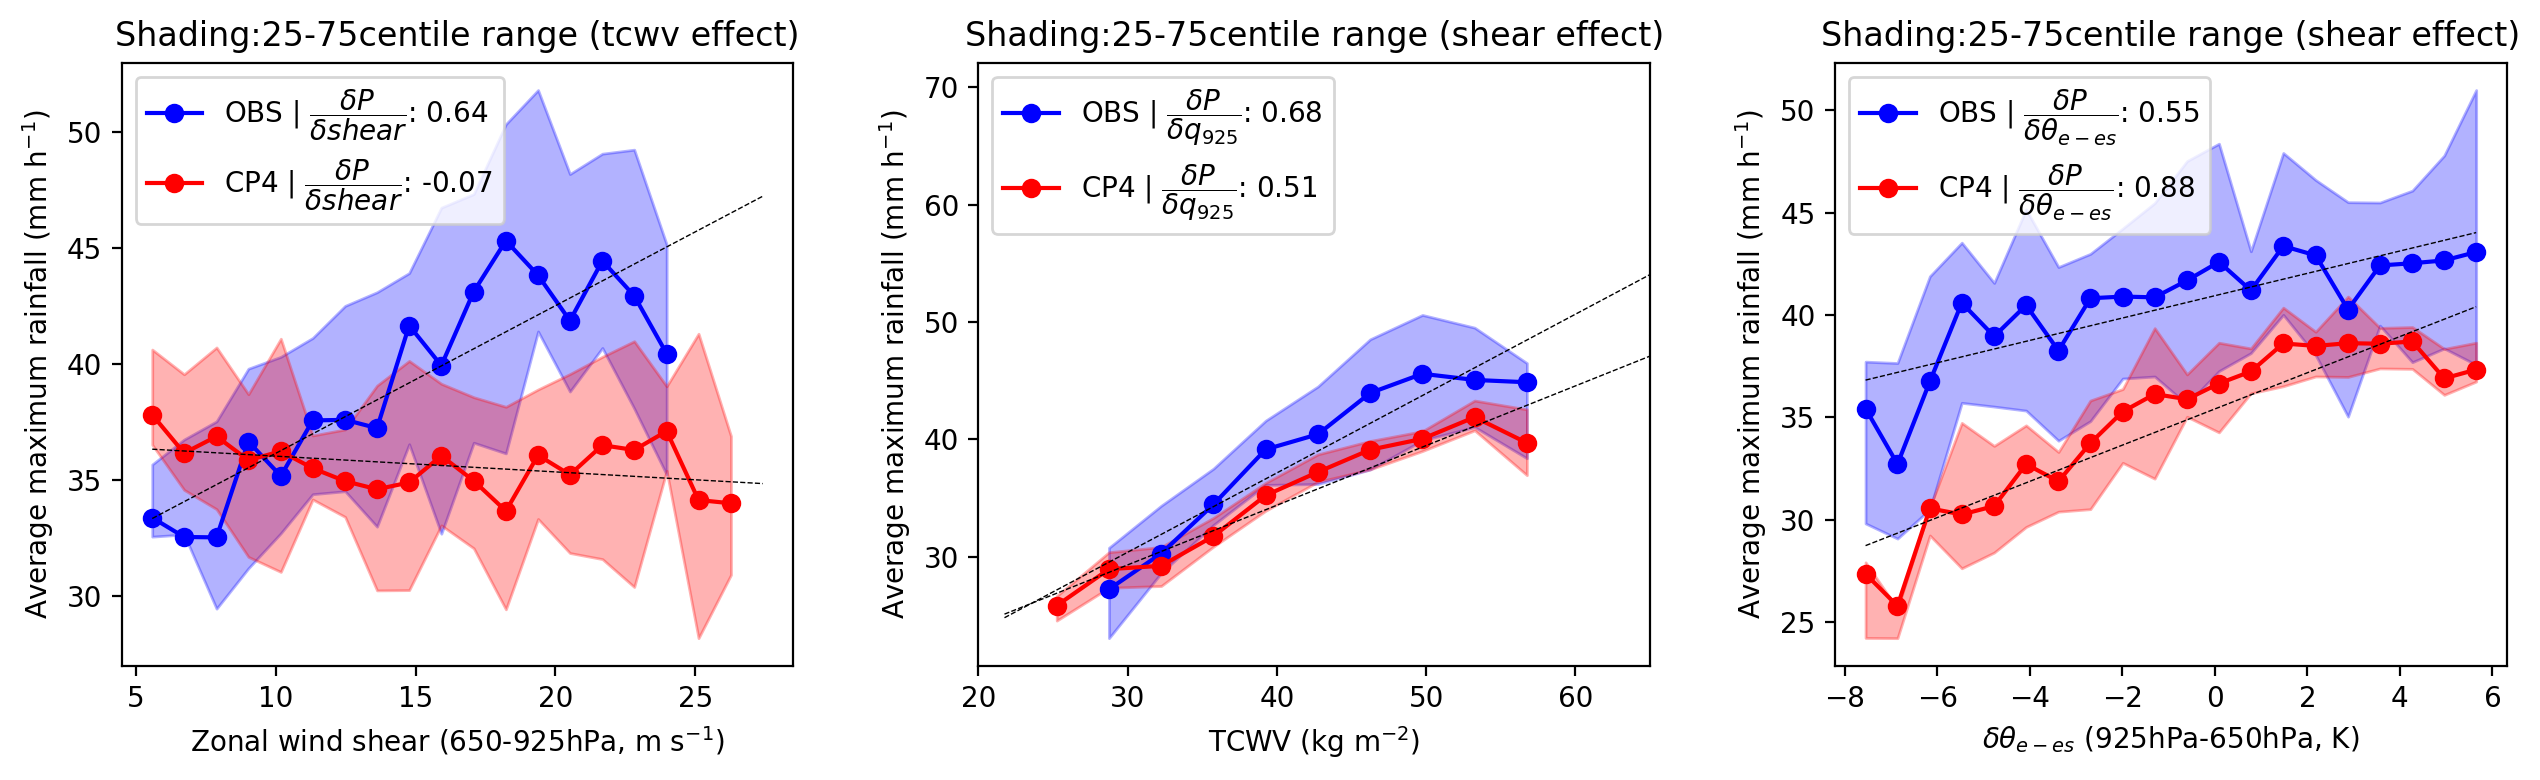

In [596]:
f = plt.figure(figsize=(13,4), dpi=200)

obs = obs_tcwv_shear
cp4 = cp4_tcwv_shear
ax = f.add_subplot(131)
plt.plot(obs['bins'],obs['pmean'], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(obs['slope'],2)))
plt.fill_between(obs['bins'],obs['p10'],obs['p90'], color='blue', alpha=0.3)
plt.fill_between(cp4['bins'],cp4['p10'],cp4['p90'], color='red', alpha=0.3)
plt.plot(cp4['bins'],cp4['pmean'], '-ro', label='CP4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(cp4['slope'],2)))
plt.plot(obs['bins'],obs['slope']*obs['bins']+obs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(cp4['bins'],cp4['slope']*cp4['bins']+cp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (tcwv effect)')
#plt.ylim(12,31)
#plt.ylim(15,33)
plt.legend(loc='upper left')

obs = obs_shear_tcwv
cp4 = cp4_shear_tcwv
ax = f.add_subplot(132)
plt.plot(obs['bins'],obs['pmean'], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(obs['slope'],2)))
plt.fill_between(obs['bins'],obs['p10'],obs['p90'], color='blue', alpha=0.3)
plt.fill_between(cp4['bins'],cp4['p10'],cp4['p90'], color='red', alpha=0.3)

plt.plot(cp4['bins'],cp4['pmean'], '-ro', label=r'CP4 | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(cp4['slope'],2)))
plt.plot(obs['bins'],obs['slope']*obs['bins']+obs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(cp4['bins'],cp4['slope']*cp4['bins']+cp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')
plt.xlabel('TCWV (kg m$^{-2}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')

#plt.ylim(12,31)
plt.xlim(20,65)
plt.legend(loc='upper left')

obs = obs_shear_theta
cp4 = cp4_shear_theta
ax = f.add_subplot(133)
plt.plot(obs['bins'],obs['pmean'], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(obs['slope'],2)))
plt.fill_between(obs['bins'],obs['p10'],obs['p90'], color='blue', alpha=0.3)
plt.fill_between(obs['bins'],cp4['p10'],cp4['p90'], color='red', alpha=0.3)
plt.plot(obs['bins'],cp4['pmean'], '-ro', label=r'CP4 | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(cp4['slope'],2)))
plt.plot(obs['bins'],obs['slope']*obs['bins']+obs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(obs['bins'],cp4['slope']*cp4['bins']+cp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'$\delta \theta _{e-es}$ (925hPa-650hPa, K)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(12,31)
#plt.ylim(1,33)
plt.legend(loc='upper left')

plt.tight_layout()
f.savefig(cnst.network_data +'figs/ENDGAME/OBS_CP4_lineplot_'+tag+'_15km_rain_HOURLY_p90.png')

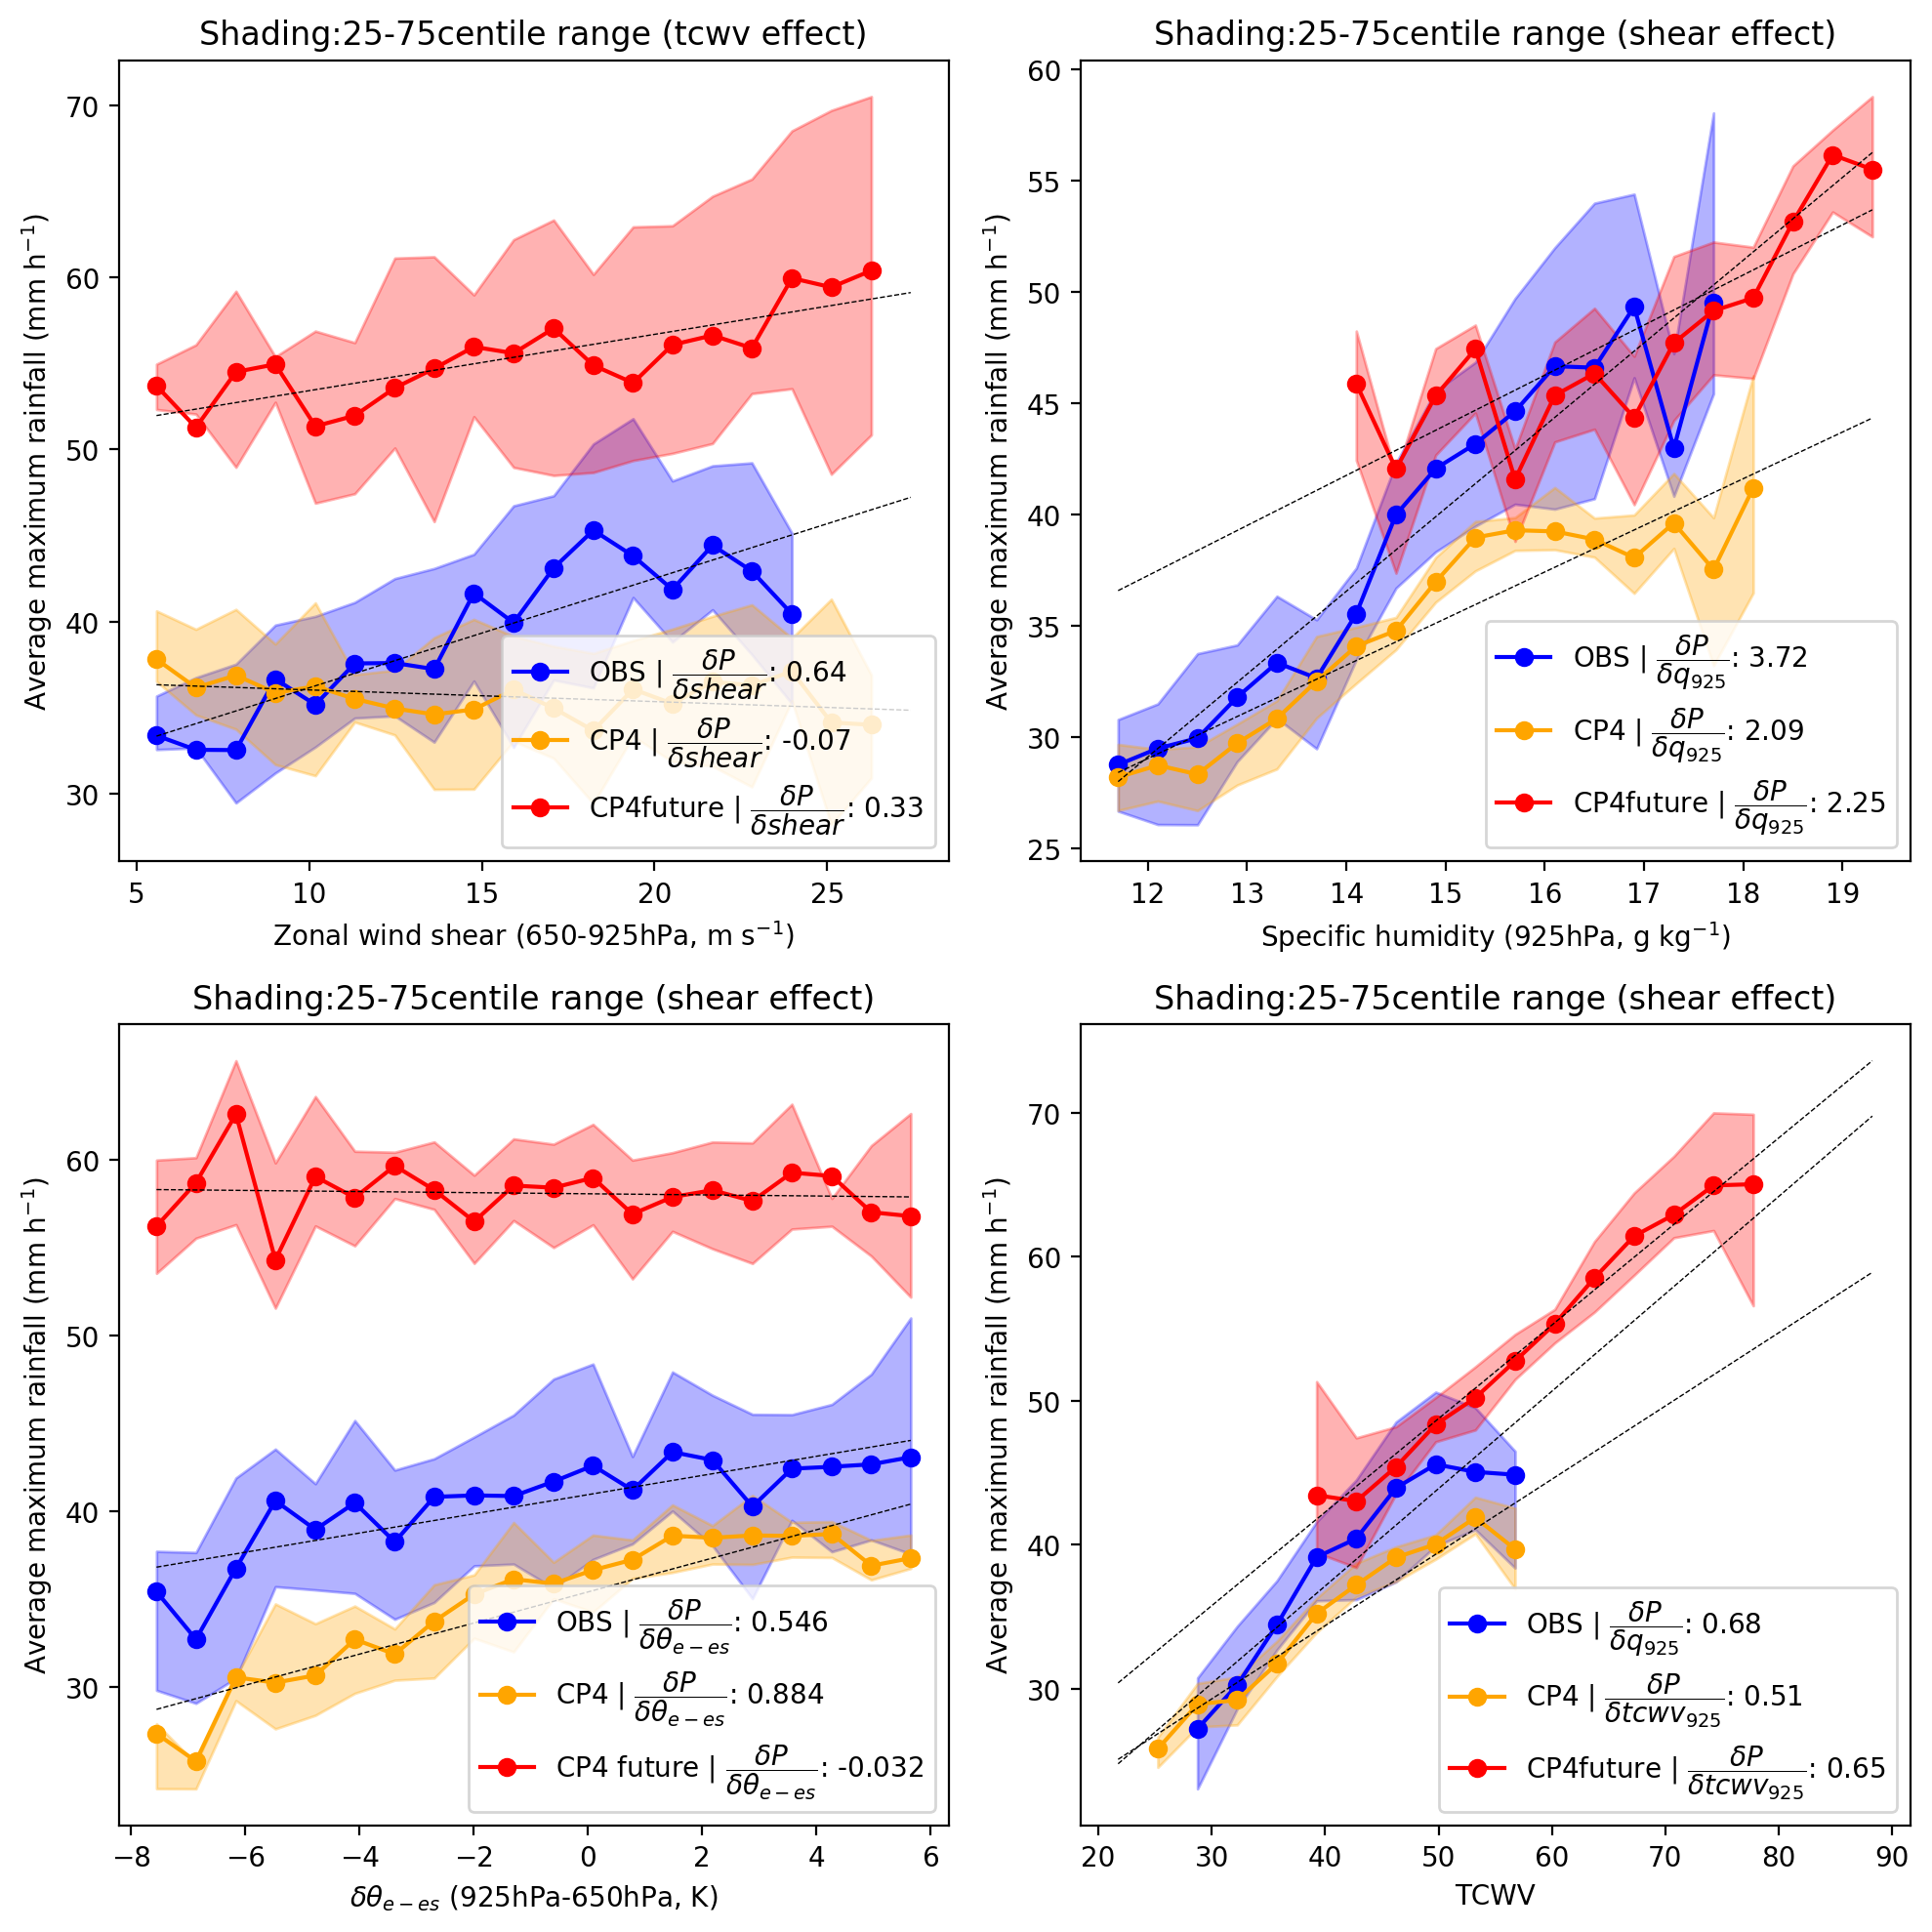

In [598]:
f = plt.figure(figsize=(10,10), dpi=200)

obs = obs_tcwv_shear
cp4 = cp4_tcwv_shear
cp4f = cp4f_tcwv_shear
ax = f.add_subplot(221)
plt.plot(obs['bins'],obs['pmean'],  '-bo', label=r'OBS | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(obs['slope'],2)))
plt.fill_between(obs['bins'],obs['p10'],obs['p90'], color='blue', alpha=0.3)
plt.fill_between(cp4['bins'],cp4['p10'],cp4['p90'], color='orange', alpha=0.3)
plt.fill_between(cp4f['bins'],cp4f['p10'],cp4f['p90'], color='red', alpha=0.3)
plt.plot(cp4['bins'],cp4['pmean'], color='orange', marker='o', label='CP4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(cp4['slope'],2)))
plt.plot(cp4f['bins'],cp4f['pmean'], '-ro', label='CP4future | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(cp4f['slope'],2)))
plt.plot(obs['bins'],obs['slope']*obs['bins']+obs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(obs['bins'],cp4['slope']*cp4['bins']+cp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(obs['bins'],cp4f['slope']*cp4f['bins']+cp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (tcwv effect)')
#plt.ylim(10,42)
#plt.ylim(15,33)
plt.legend(loc='lower right')

obs = obs_shear_q
cp4 = cp4_shear_q
cp4f = cp4f_shear_q
ax = f.add_subplot(222)
plt.plot(obs['bins'],obs['pmean'],  '-bo', label=r'OBS | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(obs['slope'],2)))
plt.fill_between(obs['bins'],obs['p10'],obs['p90'], color='blue', alpha=0.3)
plt.fill_between(cp4['bins'],cp4['p10'],cp4['p90'], color='orange', alpha=0.3)
plt.fill_between(cp4f['bins'],cp4f['p10'],cp4f['p90'], color='red', alpha=0.3)
plt.plot(cp4['bins'],cp4['pmean'], color='orange', marker='o', label=r'CP4 | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(cp4['slope'],2)))
plt.plot(cp4f['bins'],cp4f['pmean'], '-ro', label=r'CP4future | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(cp4f['slope'],2)))
plt.plot(obs['bins'],obs['slope']*obs['bins']+obs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(obs['bins'],cp4['slope']*cp4['bins']+cp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(obs['bins'],cp4f['slope']*cp4f['bins']+cp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')

#plt.ylim(10,42)
#plt.ylim(15,33)
plt.legend(loc='lower right')

         
obs = obs_shear_theta
cp4 = cp4_shear_theta
cp4f = cp4f_shear_theta
ax = f.add_subplot(223)
plt.plot(obs['bins'],obs['pmean'], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(obs['slope'],3)))
plt.fill_between(obs['bins'],obs['p10'],obs['p90'], color='blue', alpha=0.3)
plt.fill_between(cp4['bins'],cp4['p10'],cp4['p90'], color='orange', alpha=0.3)
plt.fill_between(cp4f['bins'],cp4f['p10'],cp4f['p90'], color='red', alpha=0.3)
plt.plot(cp4['bins'],cp4['pmean'], color='orange', marker='o', label=r'CP4 | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(cp4['slope'],3)))
plt.plot(cp4f['bins'],cp4f['pmean'], '-ro', label=r'CP4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(cp4f['slope'],3)))
plt.plot(obs['bins'],obs['slope']*obs['bins']+obs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(obs['bins'],cp4['slope']*cp4['bins']+cp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(obs['bins'],cp4f['slope']*cp4f['bins']+cp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'$\delta \theta _{e-es}$ (925hPa-650hPa, K)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,42)
#plt.ylim(1,33)
plt.legend(loc='lower right')

obs = obs_shear_tcwv
cp4 = cp4_shear_tcwv
cp4f = cp4f_shear_tcwv
ax = f.add_subplot(224)
plt.plot(obs['bins'],obs['pmean'], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(obs['slope'],2)))
plt.fill_between(obs['bins'],obs['p10'],obs['p90'], color='blue', alpha=0.3)
plt.fill_between(cp4['bins'],cp4['p10'],cp4['p90'], color='orange', alpha=0.3)
plt.fill_between(cp4f['bins'],cp4f['p10'],cp4f['p90'], color='red', alpha=0.3)
plt.plot(cp4['bins'],cp4['pmean'], color='orange', marker='o', label=r'CP4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(cp4['slope'],2)))
plt.plot(cp4f['bins'],cp4f['pmean'], '-ro', label=r'CP4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(cp4f['slope'],2)))
plt.plot(obs['bins'],obs['slope']*obs['bins']+obs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(obs['bins'],cp4['slope']*cp4['bins']+cp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(obs['bins'],cp4f['slope']*cp4f['bins']+cp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('TCWV')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,42)
##plt.ylim(1,33)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/CLOVER/scatter_fullWA_OBS_CP4future_hourly_p90.png')

In [558]:
tvmin = -83
tvmax = -64

pvmin = 17
pvmax = 27

avmin = 5000
avmax = 90500

thetatmin_dic_obs = plot_dic_tmin(obs_theta, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'OBS')
thetatmin_dic_cp4 = plot_dic_tmin(cp4_theta, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'CP4hist')
thetatmin_dic_cp4f = plot_dic_tmin(cp4f_theta, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'CP4fut')

wvtmin_dic_obs = plot_dic_tmin(obs_tcwv, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'OBS')
wvtmin_dic_cp4 = plot_dic_tmin(cp4_tcwv, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'CP4hist')
wvtmin_dic_cp4f = plot_dic_tmin(cp4f_tcwv, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'CP4fut')

qtmin_dic_obs = plot_dic_tmin(obs_q925, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'OBS')
qtmin_dic_cp4 = plot_dic_tmin(cp4_q925, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'CP4hist')
qtmin_dic_cp4f = plot_dic_tmin(cp4f_q925, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'CP4fut')

thetaprcp_dic_obs = plot_dic_tmin(obs_theta, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'OBS')
thetaprcp_dic_cp4 = plot_dic_tmin(cp4_theta, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'CP4hist')
thetaprcp_dic_cp4f = plot_dic_tmin(cp4f_theta, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'CP4fut')

wvprcp_dic_obs = plot_dic_prcp(obs_tcwv, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'OBS')
wvprcp_dic_cp4 = plot_dic_prcp(cp4_tcwv, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'CP4hist')
wvprcp_dic_cp4f = plot_dic_prcp(cp4f_tcwv, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'CP4fut')

qprcp_dic_obs = plot_dic_prcp(obs_q925, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'OBS')
qprcp_dic_cp4 = plot_dic_prcp(cp4_q925, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'CP4hist')
qprcp_dic_cp4f = plot_dic_prcp(cp4f_q925, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'CP4fut')

In [559]:
data_list = [qtmin_dic_obs, qtmin_dic_cp4, qtmin_dic_cp4f,qprcp_dic_obs, qprcp_dic_cp4, qprcp_dic_cp4f]

0
1
2
3
4
5


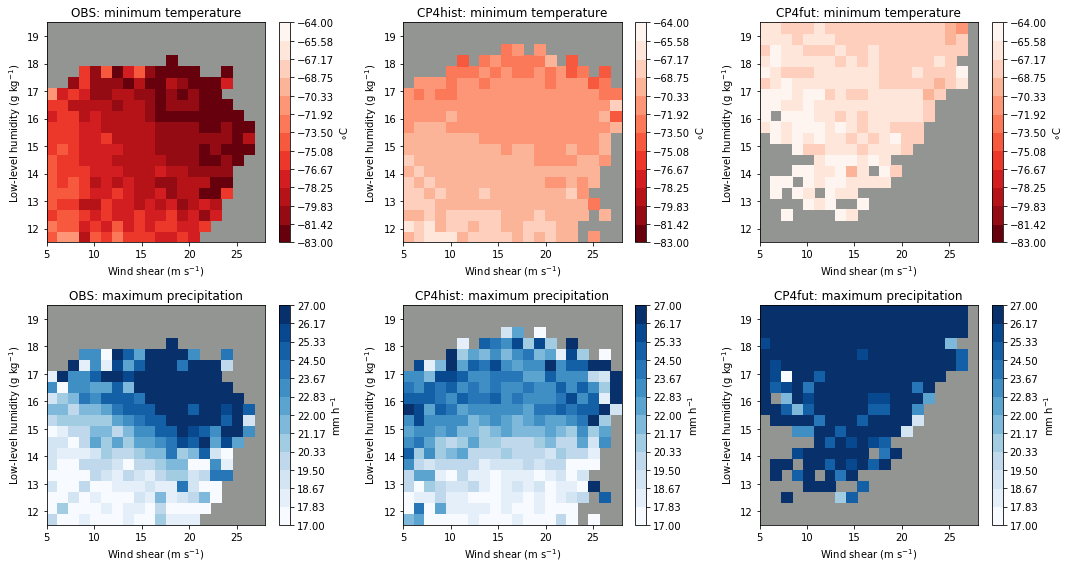

In [565]:
hist2d_six(data_list, valid=True)

In [567]:
data_list = [wvtmin_dic_obs, wvtmin_dic_cp4, wvtmin_dic_cp4f,wvprcp_dic_obs, wvprcp_dic_cp4, wvprcp_dic_cp4f]

0
1
2
3
4
5


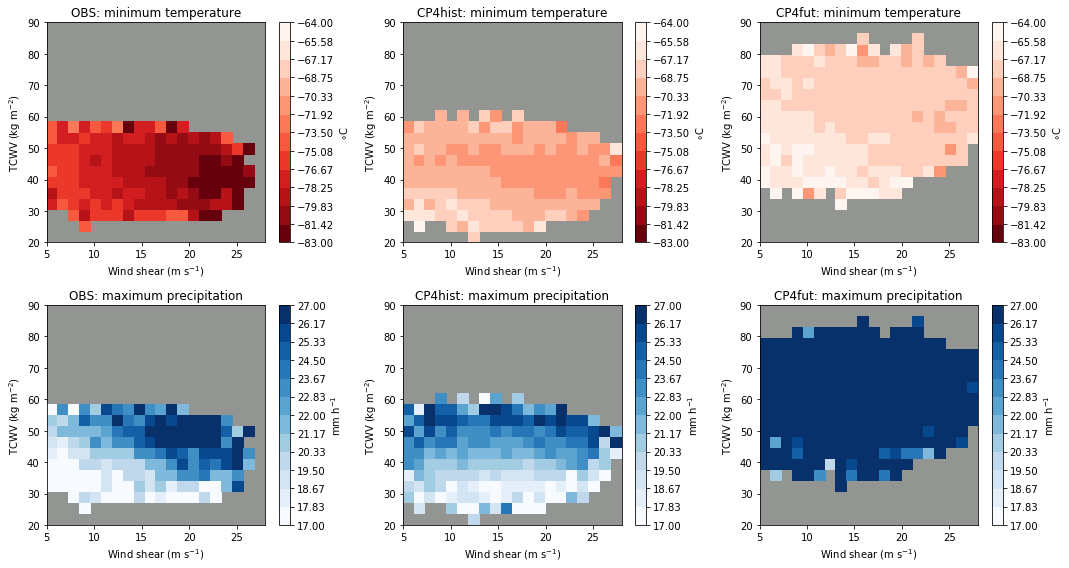

In [568]:
hist2d_six(data_list, valid=True)

In [ ]:
hist2d_quatro(data_list, valid=True)

In [ ]:
data_list = [thetatmin_dic_obs, thetatmin_dic_cp4, thetaprcp_dic_obs, thetaprcp_dic_cp4]